## (1) Import libraries

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

from kats.consts import TimeSeriesData
from kats.utils.backtesters import BackTesterSimple

from kats.models.linear_model import LinearModel, LinearModelParams
from kats.models.quadratic_model import QuadraticModel, QuadraticModelParams
from kats.models.arima import ARIMAModel, ARIMAParams
from kats.models.sarima import SARIMAModel, SARIMAParams
from kats.models.theta import ThetaModel, ThetaParams
from kats.models.holtwinters import HoltWintersModel, HoltWintersParams
from kats.models.stlf import STLFModel, STLFParams
from kats.models.prophet import ProphetModel, ProphetParams
# from kats.models.lstm import LSTMModel, LSTMParams # this LSTM implementation is very slow

from kats.models.var import VARModel, VARParams
from kats.models.bayesian_var import BayesianVAR, BayesianVARParams

from kats.utils.backtesters import BackTesterExpandingWindow

import warnings
warnings.simplefilter(action='ignore')

In [2]:
# Record version of key libraries
from importlib.metadata import version

print('kats==%s' % version('kats'))

kats==0.1.0


## (2) Get data

In [3]:
# Read local data
uni_data_df = pd.read_csv("../data/air_passengers.csv")
multi_data_df = pd.read_csv("../data/multi_ts.csv", index_col=0)

# Set column names so that constructor can recognise the data
# time column is required to be recognised as dates, and any number of value columns can be present
uni_data_df.columns = ['time', 'value']
print(uni_data_df.head())

multi_data_df.columns = ['time', 'v1', 'v2']
print(multi_data_df.head())

         time  value
0  1949-01-01    112
1  1949-02-01    118
2  1949-03-01    132
3  1949-04-01    129
4  1949-05-01    121
         time     v1    v2
0  2017-03-12 -0.109  53.8
1  2017-03-13  0.000  53.6
2  2017-03-14  0.178  53.5
3  2017-03-15  0.339  53.5
4  2017-03-16  0.373  53.4


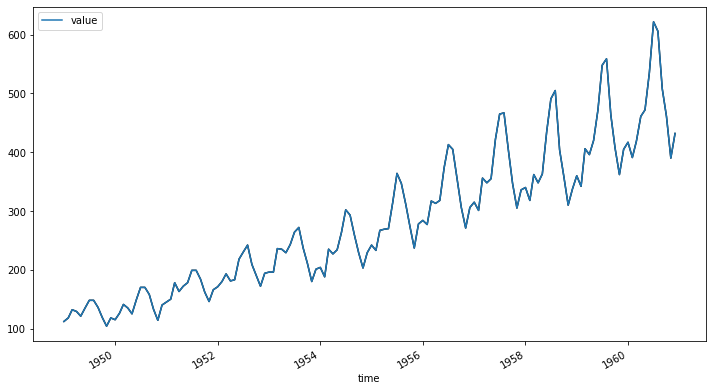

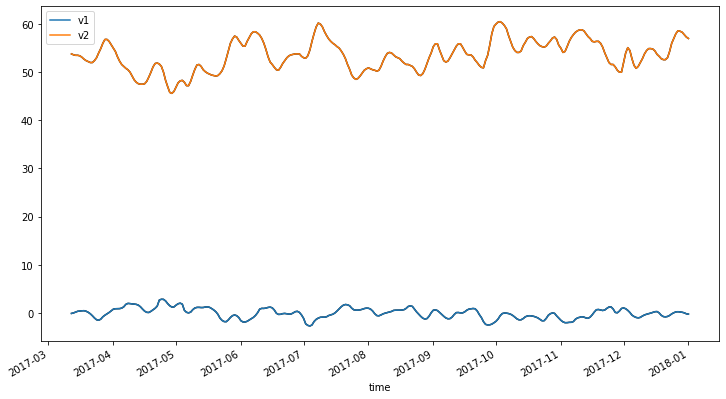

In [4]:
# Convert data object from pandas dataframe into kats object
uni_ts = TimeSeriesData(uni_data_df, time_col_name='time')
multi_ts = TimeSeriesData(multi_data_df, time_col_name='time')

# Visualise data
uni_ts.plot(cols=['value'])
plt.show()

multi_ts.plot(cols=['v1', 'v2'])
plt.show()

## (3A) Compare models - univariate

Models supported are :
- Linear
- Quadratic
- ARIMA
- SARIMA
- Holt-Winters
- Prophet
- AR-Net
- LSTM
- Theta
- STLF

In [46]:
# Test all models available in kats

# Store all models together with parameters. There is no need to fit models first
uni_model_param_dict = {}

# Setup linear model
linear_params = LinearModelParams()
uni_model_param_dict['linear_model'] = (linear_params, LinearModel)

# Setup quadratic model
quadratic_params = QuadraticModelParams()
uni_model_param_dict['quadratic_model'] = (quadratic_params, QuadraticModel)

# Setup arima model
arima_params = ARIMAParams(p=2, d=1, q=1)
uni_model_param_dict['arima_model'] = (arima_params, ARIMAModel)

# Setup sarima model
sarima_params = SARIMAParams(p=2, d=1, q=1)
uni_model_param_dict['sarima_model'] = (sarima_params, SARIMAModel)

# Setup theta model
theta_params = ThetaParams()
uni_model_param_dict['theta_model'] = (theta_params, ThetaModel)

# Setup holtwinters model
hw_params = HoltWintersParams()
uni_model_param_dict['hw_model'] = (hw_params, HoltWintersModel)

# Setup stlf model
stlf_params = STLFParams(method='prophet', m=12)
uni_model_param_dict['stlf_model'] = (stlf_params, STLFModel)

# Setup prophet model
prophet_params = ProphetParams(seasonality_mode='multiplicative')
uni_model_param_dict['prophet_model'] = (prophet_params, ProphetModel)

In [48]:
# Run backtesting for each model

uni_backtesting_errors = {}

for name, obj_tuple in uni_model_param_dict.items():
    print('Testing model %s.........' % name)
    param, model = obj_tuple

    # Setup backtesting object
    backtester_obj = BackTesterExpandingWindow(
        error_methods=['mape', 'smape', 'mae'],
        data=uni_ts,
        params=param,
        model_class=model,
        start_train_percentage=50, #train percentage increases per fold
        end_train_percentage=75,
        test_percentage=25,
        expanding_steps=3 #number of folds
    )

    # Run backtesting
    backtester_obj.run_backtest()

    # Store error metric
    uni_backtesting_errors[name] = {}
    for error, value in backtester_obj.errors.items():
        uni_backtesting_errors[name][error] = value

# Convert errors into dataframe
uni_backtesting_err_df = pd.DataFrame.from_dict(uni_backtesting_errors).transpose()

# Sort model ranking by MAPE
uni_backtesting_err_df = uni_backtesting_err_df.sort_values(by='mape', ascending=True)

print(uni_backtesting_err_df)

Testing model linear_model.........
Testing model quadratic_model.........
Testing model arima_model.........
Testing model sarima_model.........
Testing model theta_model.........
Testing model hw_model.........
Testing model stlf_model.........


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Testing model prophet_model.........


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                     mape     smape        mae
prophet_model    0.087252  0.089034  31.986103
stlf_model       0.096418  0.099383  34.872278
arima_model      0.114493  0.121891  46.595001
linear_model     0.117307  0.125707  47.800546
quadratic_model  0.138460  0.138469  53.321068
hw_model         0.172702  0.178684  66.136494
sarima_model     0.174241  0.198778  70.493988
theta_model      0.174968  0.191688  68.784334


## (3B) Compare models - multivariate

Models supported are :
- VAR
- Bayesian VAR

In [53]:
# Test all models available in kats

# Store all models together with parameters. There is no need to fit models first
multi_model_param_dict = {}

# Setup var model
var_params = VARParams()
multi_model_param_dict['var_model'] = (var_params, VARModel)

# Setup bayesian var model
bayesvar_params = BayesianVARParams()
multi_model_param_dict['bayesvar_model'] = (bayesvar_params, BayesianVAR)

In [54]:
# # Run backtesting for each model

# multi_backtesting_errors = {}

# for name, obj_tuple in multi_model_param_dict.items():
#     print('Testing model %s.........' % name)
#     param, model = obj_tuple

#     # Setup backtesting object
#     # NOTE - this function only supports univariate for now
#     backtester_obj = BackTesterExpandingWindow(
#         error_methods=['mape', 'smape', 'mae'],
#         data=multi_ts,
#         params=param,
#         model_class=model,
#         start_train_percentage=50, #train percentage increases per fold
#         end_train_percentage=75,
#         test_percentage=25,
#         expanding_steps=3 #number of folds
#     )

#     # Run backtesting
#     backtester_obj.run_backtest()

#     # Store error metric
#     multi_backtesting_errors[name] = {}
#     for error, value in backtester_obj.errors.items():
#         multi_backtesting_errors[name][error] = value

# # Convert errors into dataframe
# multi_backtesting_err_df = pd.DataFrame.from_dict(multi_backtesting_errors).transpose()

# # Sort model ranking by MAPE
# multi_backtesting_err_df = multi_backtesting_err_df.sort_values(by='mape', ascending=True)

# print(multi_backtesting_err_df)

Testing model var_model.........


ValueError: Shape of passed values is (2, 2), indices imply (148, 2)

## (4) Fit model

In [69]:
# Fit univariate model
prophet_params = ProphetParams(seasonality_mode='multiplicative')
prophet_model = ProphetModel(uni_ts, prophet_params)
prophet_model.fit()

# Fit multivariate model
var_params = VARParams()
var_model = VARModel(multi_ts, var_params)
var_model.fit()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## (5) Generate predictions

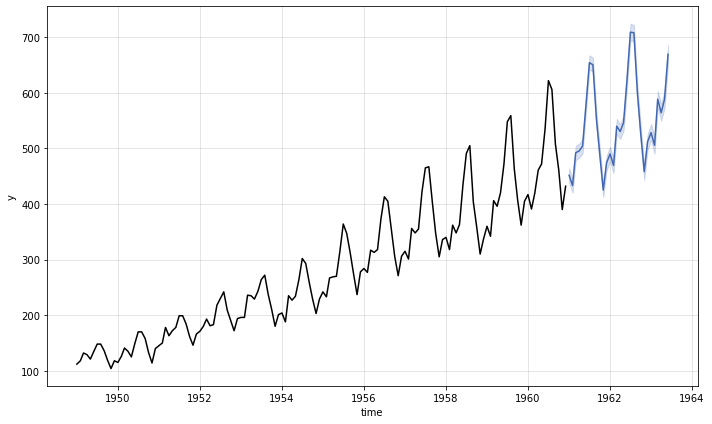

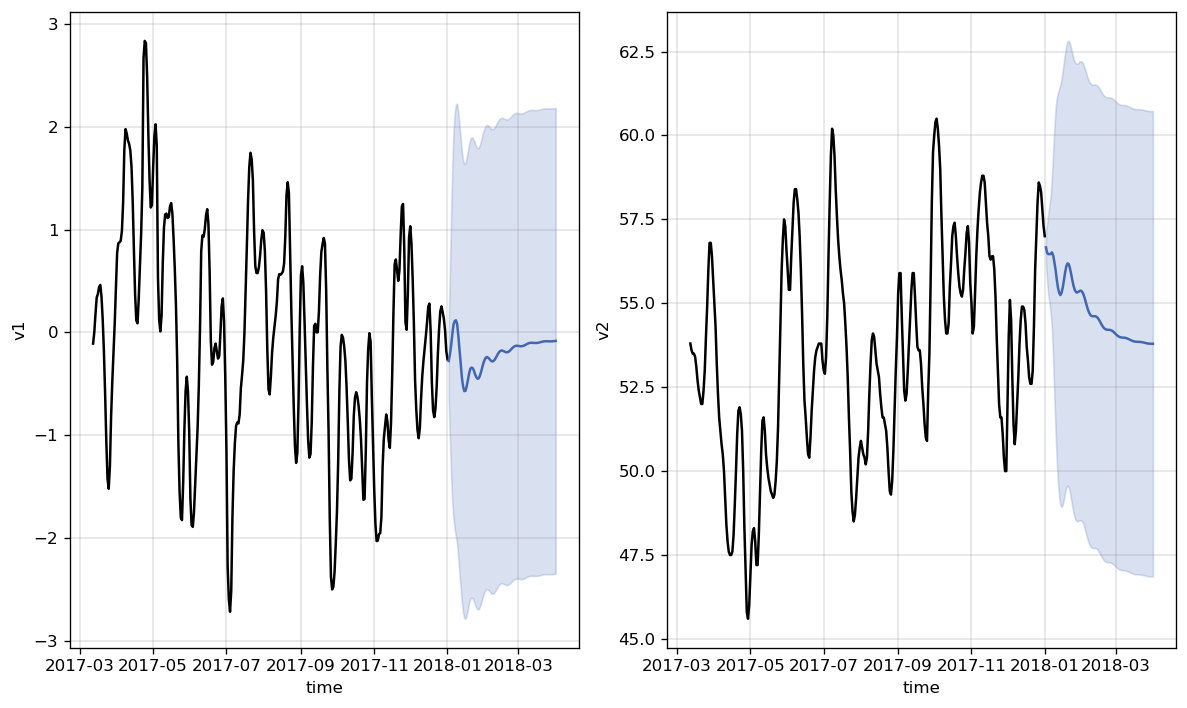

In [71]:
# Make prediction for next 30 months
uni_fcst = prophet_model.predict(steps=30, freq="MS")
prophet_model.plot()

multi_fcst = var_model.predict(steps=90)
var_model.plot()

plt.show()